<a href="https://colab.research.google.com/github/dhruvprabhu/Tweet-Support-Classification/blob/main/BTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install emoji
!pip install wordninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wordninja: filename=wordninja-2.0.0-py3-none-any.whl size=541530 sha256=09b71094387da7b75fda146b2a4705123651034cfe2facc35d16f865303aa43a
  Stored in directory: /root/.cache/pip/wheels/aa/44/3a/f2a5c1859b8b541ded969b4cd12d0a58897f12408f4f51e084
Successfully built wordninja


In [ ]:
import pandas as pd
import random as rd
import re
import emoji
import math
import string
import numpy as np
import wordninja
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df= pd.read_csv('/content/drive/MyDrive/Deep Learning/annotations - Final_Dataset.csv')
df = df[df['Reply_Class'] != 'Lang']

# Preprocessing


In [ ]:

def pre_process_tweet(tweet):
    # Remove \n from the end of the sentence
    tweet = tweet.strip('\n')

    # Convert emojis to their descriptions
    tweet = emoji.demojize(tweet)
    # Add spaces between emoji descriptions
    tweet = re.sub(r'(:\w+:)', lambda x: x.group(0).replace(':', ' '), tweet)

    # Remove any URL
    tweet = re.sub(r"http\S+", "", tweet)
    tweet = re.sub(r"www\S+", "", tweet)

    # Convert underscore-separated words to space-separated words
    tweet = re.sub(r'_', ' ', tweet)

    # Convert dash-separated words to space-separated words
    tweet = re.sub(r'-', ' ', tweet)

    # Replace &amp with 'and'
    tweet = tweet.replace('&amp','and')
    tweet = tweet.replace('&AMP','and')

    # Replace U.S. with 'usa'
    tweet = tweet.replace('U.S.', 'usa')
    tweet = tweet.replace('US','usa')
    # Remove colons from the end of the sentences (if any)
    tweet = tweet.strip()
    if tweet.endswith(':'):
        tweet = tweet[:-1]

    # Split tweet into words
    # words = tweet.split()

    # # Iterate over words and replace hashtag words
    # for i, word in enumerate(words):
    #     if word.startswith('#'):
    #         words[i] = separate_hashtag_words(word)

    # tweet = ' '.join(words)
    # tweet = re.sub(r'#\w+', lambda x: separate_hashtag_words(x.group()), tweet)
    # Remove hash-tags symbols and add spaces between words
    # tweet = re.sub(r'#(\w+)', r' \1', tweet)

    # Convert every word to lowercase
    tweet = tweet.lower()


    tweet = tweet.replace('#', '')
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Trim extra spaces
    tweet = " ".join(tweet.split())

    return tweet

# Example usage:
tweet = "#sanctionpakistan"
processed_tweet = pre_process_tweet(tweet)
print(processed_tweet)
tweet = "😙😚Here is an 'example' tweet! @user #example PM's us US  #sanctionpakistan http://example.com  😂💀💀do a lot !!"
processed_tweet = pre_process_tweet(tweet)
print(processed_tweet)



sanctionpakistan
kissing face with smiling eyes kissing face with closed eyes here is an example tweet user example pms us usa sanctionpakistan face with tears of joy skull skull do a lot


In [ ]:
df['Text'] = df['Text'].apply(pre_process_tweet)
df['Reply'] = df['Reply'].apply(pre_process_tweet)

In [ ]:
# Used to seperate words
df['Text'] = df['Text'].apply(lambda x: ' '.join(wordninja.split(x)))
df['Reply'] = df['Reply'].apply(lambda x: ' '.join(wordninja.split(x)))

In [ ]:
print(df['Reply'][11])

sanction pakistan united nations united nations high commissioner for human rights united nations general assembly international court of justice international courts


# Tokenization and Padding


In [ ]:
# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Text'] + df['Reply'])

max_sequence_length = 60

sequences_text = tokenizer.texts_to_sequences(df['Text'])
sequences_reply = tokenizer.texts_to_sequences(df['Reply'])

padded_sequences_text = pad_sequences(sequences_text, maxlen=max_sequence_length, padding='post')
padded_sequences_reply = pad_sequences(sequences_reply, maxlen=max_sequence_length, padding='post')



reply_tokens = [tokenizer.index_word.get(token, '') for token in padded_sequences_reply[11]]
print("Reply tokens:", reply_tokens)
print(padded_sequences_reply[11])

# Glove dictionary creation

In [ ]:

words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, '/content/drive/MyDrive/Deep Learning/glove.twitter.27B.50d.txt')
words

#Create Embeddings

In [ ]:


# Function to get embeddings for sequences
def get_embeddings(sequences, word_dict):
    embedding_dim = 50
    # embedding_dim = len(next(iter(word_dict.values())))  # Dimension of GloVe embeddings
    num_words = len(tokenizer.word_index) + 1  # Adding 1 for padding token (index 0)

    # Initialize embeddings matrix
    embeddings_matrix = np.zeros((len(sequences), max_sequence_length, embedding_dim))

    # Iterate over sequences
    for i, seq in enumerate(sequences):
        # Iterate over tokens in each sequence
        for j, token_index in enumerate(seq):
            if token_index != 0:  # Skip padding token
                word = tokenizer.index_word.get(token_index)
                if word in word_dict:
                    embeddings_matrix[i, j, :] = word_dict[word]
                else:
                    # If word not in GloVe dictionary, use zero vector
                    embeddings_matrix[i, j, :] = np.zeros(embedding_dim)

    return embeddings_matrix

# Get embeddings for padded_sequences_text and padded_sequences_reply
embeddings_text = get_embeddings(padded_sequences_text, words)
embeddings_reply = get_embeddings(padded_sequences_reply, words)

# Print the shape of embeddings for verification
# print("Shape of embeddings_text:", embeddings_text.shape)
# print("Shape of embeddings_reply:", embeddings_reply.shape)

print(embeddings_reply.shape)
print(embeddings_text.shape)

(2864, 60, 50)
(2864, 60, 50)


# CREATION OF TRAIN, TEST, VAL

In [ ]:
y=df['Reply_Class']

In [ ]:

import numpy as np
from sklearn.model_selection import train_test_split

# Assuming you have your data stored in embeddings_text and embeddings_reply arrays
# Split the data into training (80%), validation (10%), and test (10%) sets
# X_train_text, X_temp_text = train_test_split(embeddings_text, test_size=0.2, random_state=42)
# X_val_text, X_test_text = train_test_split(X_temp_text, test_size=0.5, random_state=42)

# X_train_reply, X_temp_reply = train_test_split(embeddings_reply, test_size=0.2, random_state=42)
# X_val_reply, X_test_reply = train_test_split(X_temp_reply, test_size=0.5, random_state=42)

# # Assuming you have labels stored in a variable y
# # Split the labels accordingly
# y_train, y_temp = train_test_split(y, test_size=0.2, random_state=42)
# y_val, y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

# Split indices of the embeddings arrays
indices = range(len(embeddings_text))
train_indices, temp_indices = train_test_split(indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Use the split indices to extract the corresponding rows from embeddings_text and embeddings_reply
X_train_text = embeddings_text[train_indices]
X_val_text = embeddings_text[val_indices]
X_test_text = embeddings_text[test_indices]

X_train_reply = embeddings_reply[train_indices]
X_val_reply = embeddings_reply[val_indices]
X_test_reply = embeddings_reply[test_indices]

# Use the split indices to extract the corresponding labels
y_train = y.iloc[train_indices]
y_val = y.iloc[val_indices]
y_test = y.iloc[test_indices]
# Convert the arrays to numpy arrays
X_train_text = np.array(X_train_text)
X_val_text = np.array(X_val_text)
X_test_text = np.array(X_test_text)

X_train_reply = np.array(X_train_reply)
X_val_reply = np.array(X_val_reply)
X_test_reply = np.array(X_test_reply)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Print the shapes to verify
print("X_train_text shape:", X_train_text.shape)
print("X_val_text shape:", X_val_text.shape)
print("X_test_text shape:", X_test_text.shape)
print("X_train_reply shape:", X_train_reply.shape)
print("X_val_reply shape:", X_val_reply.shape)
print("X_test_reply shape:", X_test_reply.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)




X_train_text shape: (2291, 60, 50)
X_val_text shape: (286, 60, 50)
X_test_text shape: (287, 60, 50)
X_train_reply shape: (2291, 60, 50)
X_val_reply shape: (286, 60, 50)
X_test_reply shape: (287, 60, 50)
y_train shape: (2291,)
y_val shape: (286,)
y_test shape: (287,)


#LSTM MODEL

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Concatenate, Flatten, Input, Dropout, BatchNormalization
import tensorflow as tf
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import keras

In [ ]:
def build_model(input_shape):
    # Input layers for tweet and reply text embeddings
    tweet_input = Input(shape=input_shape)
    reply_input = Input(shape=input_shape)

    # LSTM layers for tweet and reply sequences
    lstm_tweet = LSTM(64, dropout=0.4)(tweet_input)
    lstm_reply = LSTM(64, dropout=0.4)(reply_input)

    # Concatenate LSTM outputs
    concatenated = Concatenate()([lstm_tweet, lstm_reply])

    # Flatten the concatenated output

    # Dense layers for classification with dropout
    dense1 = Dense(64, activation='relu')(concatenated)
    dense1_dropout = Dropout(0.4)(dense1)

    # Output layer
    output = Dense(3, activation='softmax')(dense1_dropout)  # 3 classes: positive, negative, neutral

    # Build and compile the model
    model = Model(inputs=[tweet_input, reply_input], outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model



In [ ]:



# Define the filepath to save the best model in Google Drive
checkpoint_filepath = '/content/drive/MyDrive/Deep Learning/type_1.h5'

# Define the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

# Assuming input_shape is the shape of the embeddings, e.g., (embedding_length, embedding_dimension)
input_shape = (60, 50)  # Example shape

# Convert string labels to integer labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Define the model
model = build_model(input_shape)
model.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 60, 50)]             0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 60, 50)]             0         []                            
                                                                                                  
 lstm_18 (LSTM)              (None, 64)                   29440     ['input_19[0][0]']            
                                                                                                  
 lstm_19 (LSTM)              (None, 64)                   29440     ['input_20[0][0]']            
                                                                                            

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


Epoch 1/50
72/72 [==============================] - ETA: 0s - loss: 1.0823 - accuracy: 0.3907
Epoch 1: val_accuracy improved from -inf to 0.42657, saving model to /content/drive/MyDrive/Deep Learning/type_1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 47s 30ms/step - loss: 1.0823 - accuracy: 0.3907 - val_loss: 1.0484 - val_accuracy: 0.4266
Epoch 2/50
70/72 [============================>.] - ETA: 0s - loss: 1.0274 - accuracy: 0.4848
Epoch 2: val_accuracy improved from 0.42657 to 0.49650, saving model to /content/drive/MyDrive/Deep Learning/type_1.h5
72/72 [==============================] - 1s 10ms/step - loss: 1.0274 - accuracy: 0.4845 - val_loss: 0.9981 - val_accuracy: 0.4965
Epoch 3/50
67/72 [==========================>...] - ETA: 0s - loss: 0.9875 - accuracy: 0.5149
Epoch 3: val_accuracy improved from 0.49650 to 0.54545, saving model to /content/drive/MyDrive/Deep Learning/type_1.h5
72/72 [==============================] - 1s 11ms/step - loss: 0.9865 - accuracy: 0.5146 - val_loss: 0.9386 - val_accuracy: 0.5455
Epoch 4/50
72/72 [==============================] - ETA: 0s - loss: 0.9388 - accuracy: 0.5653
Epoch 4: val_accuracy improved from 0.54545 to 0.55944, saving model to /content/drive/My

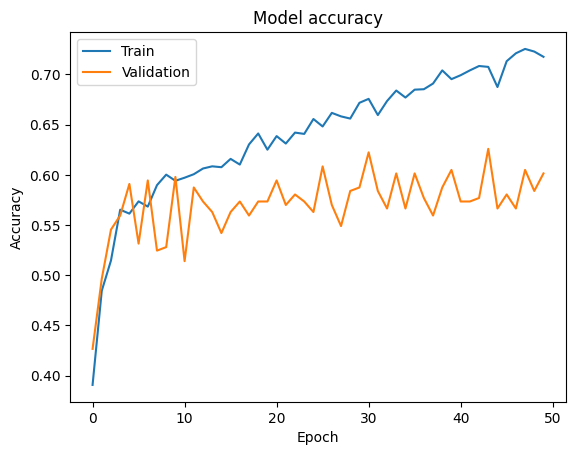

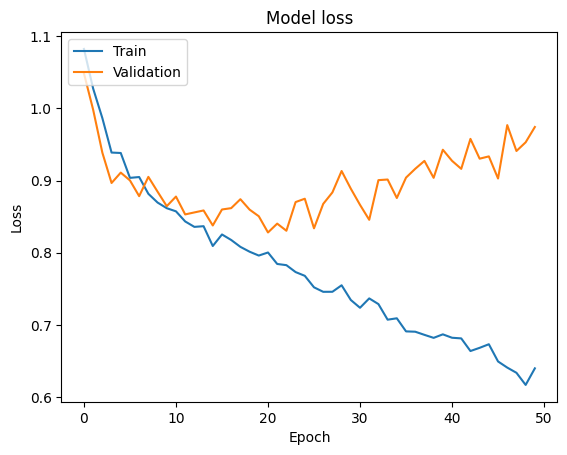

In [ ]:
# Train the model with ModelCheckpoint callback
history = model.fit([X_train_text, X_train_reply], y_train_encoded,
                    validation_data=([X_val_text, X_val_reply], y_val_encoded),
                    epochs=50, batch_size=32,
                    callbacks=[checkpoint])
# Plot training history
plot_training(history)


In [ ]:
best_model = keras.models.load_model(checkpoint_filepath)

# Evaluate the best model on test data
test_loss, test_accuracy = best_model.evaluate([X_test_text, X_test_reply], y_test_encoded, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

18/18 [==============================] - 1s 5ms/step - loss: 0.9366 - accuracy: 0.6167
Test Loss: 0.9365996718406677
Test Accuracy: 0.6167247295379639


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
best_model = keras.models.load_model(checkpoint_filepath)

# Make predictions on the test data
y_pred = best_model.predict([X_test_text, X_test_reply])
y_pred_classes = np.argmax(y_pred, axis=1)

# Define the class labels
class_labels = [-1, 0, 1]

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes, labels=class_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# TYPE-2


In [ ]:
def build_model(input_shape):
    # Input layers for tweet and reply text embeddings
    tweet_input = Input(shape=input_shape)
    reply_input = Input(shape=input_shape)

    # LSTM layers for tweet and reply sequences
    lstm_tweet = LSTM(64, dropout=0.4, return_sequences=True)(tweet_input)
    lstm_reply = LSTM(64, dropout=0.4, return_sequences=True)(reply_input)

    # Concatenate LSTM outputs
    concatenated = Concatenate(axis=-1)([lstm_tweet, lstm_reply])
    flattened = Flatten()(concatenated)

    # Dense layers for classification
    dense1 = Dense(2048, activation='relu')(flattened)
    dense1_dropout = Dropout(0.4)(dense1)
    dense2 = Dense(512, activation='relu')(dense1_dropout)
    dense2_dropout = Dropout(0.4)(dense2)
    dense3 = Dense(64, activation='relu')(dense2_dropout)
    dense3_dropout = Dropout(0.4)(dense3)

    # Output layer
    output = Dense(3, activation='softmax')(dense3_dropout)  # 3 classes: positive, negative, neutral

    # Build and compile the model with specified learning rate
    optimizer = Adam(learning_rate=1e-5)
    model = Model(inputs=[tweet_input, reply_input], outputs=output)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:



# Define the filepath to save the best model in Google Drive
checkpoint_filepath = '/content/drive/MyDrive/Deep Learning/type_2.h5'

# Define the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

# Assuming input_shape is the shape of the embeddings, e.g., (embedding_length, embedding_dimension)
input_shape = (60, 50)  # Example shape

# Convert string labels to integer labels using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Define the model
model = build_model(input_shape)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 60, 50)]             0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 60, 50)]             0         []                            
                                                                                                  
 lstm_10 (LSTM)              (None, 60, 64)               29440     ['input_11[0][0]']            
                                                                                                  
 lstm_11 (LSTM)              (None, 60, 64)               29440     ['input_12[0][0]']            
                                                                                            

Epoch 1/100
69/72 [===========================>..] - ETA: 0s - loss: 1.0925 - accuracy: 0.3845
Epoch 1: val_accuracy improved from -inf to 0.43706, saving model to /content/drive/MyDrive/Deep Learning/type_2.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


72/72 [==============================] - 9s 64ms/step - loss: 1.0920 - accuracy: 0.3867 - val_loss: 1.0582 - val_accuracy: 0.4371
Epoch 2/100
71/72 [============================>.] - ETA: 0s - loss: 1.0655 - accuracy: 0.4199
Epoch 2: val_accuracy improved from 0.43706 to 0.48601, saving model to /content/drive/MyDrive/Deep Learning/type_2.h5
72/72 [==============================] - 4s 56ms/step - loss: 1.0644 - accuracy: 0.4212 - val_loss: 1.0253 - val_accuracy: 0.4860
Epoch 3/100
70/72 [============================>.] - ETA: 0s - loss: 1.0503 - accuracy: 0.4437
Epoch 3: val_accuracy improved from 0.48601 to 0.50350, saving model to /content/drive/MyDrive/Deep Learning/type_2.h5
72/72 [==============================] - 2s 26ms/step - loss: 1.0477 - accuracy: 0.4465 - val_loss: 1.0092 - val_accuracy: 0.5035
Epoch 4/100
69/72 [===========================>..] - ETA: 0s - loss: 1.0245 - accuracy: 0.4728
Epoch 4: val_accuracy did not improve from 0.50350
72/72 [=============================

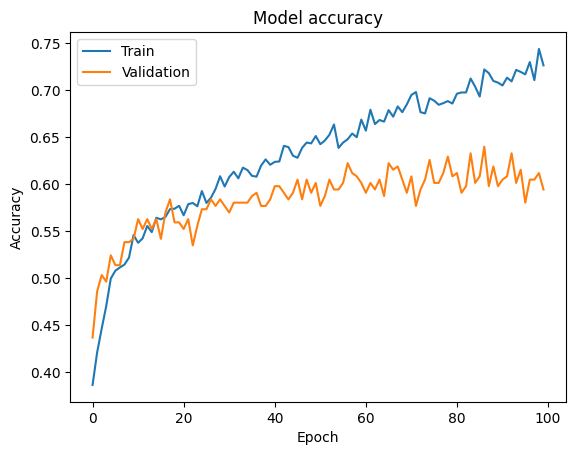

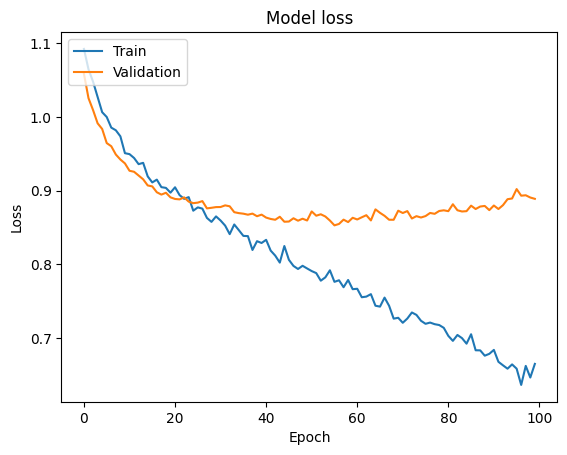

In [ ]:
# Train the model with ModelCheckpoint callback
history = model.fit([X_train_text, X_train_reply], y_train_encoded,
                    validation_data=([X_val_text, X_val_reply], y_val_encoded),
                    epochs=100, batch_size=32,
                    callbacks=[checkpoint])
# Plot graph
plot_training(history)

In [ ]:
best_model = keras.models.load_model(checkpoint_filepath)

# Evaluate the best model on test data
test_loss, test_accuracy = best_model.evaluate([X_test_text, X_test_reply], y_test_encoded, batch_size=16)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

18/18 [==============================] - 1s 6ms/step - loss: 0.9083 - accuracy: 0.6132
Test Loss: 0.9083205461502075
Test Accuracy: 0.6132404208183289
